## Generative Adversarial Network

Generative Adversarial Networks a.k.a GANs, are popular generative neural networks. GANs have demonstrated their effectiveness in nearly every problem in computer vision. The GAN works by training a pair of networks, Generator and Discriminator, with competing loss terms. As an analogy, we can think of these networks as an art-forger and the other, an art-expert. In GAN literature the Generator is the art-forger and the Discriminator is the art-expert. The Generator is trained to produce fake images (forgeries) to deceive the art-expert (Discriminator). The Discriminator which receives both the real images and fake images tries to distinguish between them to identify the fake images. The Generator uses the feedback from the Discriminator to improve it generation. Both the models are trained simulataneously and are always in competition with each other. This competition between the Generator and Discriminator drives them to improve their respective models continuously. The  model converges when the Generator produces fake images that are indistinguishable from the real images.  <br>

In this setup, the Generator does not have access to the real images whereas the Discriminator has access to both the real and the generated fake images. 

Let us define Discriminator D that takes an image as input and produces a number **(0/1)** as output and a Generator G that takes random noise as input and outputs a fake image. In practice, G and D are trained alternately i.e., For a fixed generator G, the Discriminator D is trained to classify the training data as real (output a value close to 1) or fake(output a value close to 0). Subsequenty, we freeze the Discriminator and train the Generator G to produce an image (fake) that outputs a value close to 1 (real) when passed through the Discriminator D. Thus, if the Generator is perfectly trained then the Discriminator D will be maximally confused by the images generated by G and predict 0.5 for all the inputs. 

**It will be ideal to solve this assignemnet on a computer with a GPU**. The Coursera platform does not support a GPU. You may want to explore [Google Colab](https://www.youtube.com/watch?v=inN8seMm7UI&ab_channel=TensorFlow) or [Kaggle](https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu)

Along with submitting the Python notebook, save the notebook along with its output after executing all the cells as a .html file and submit the html file as well. 

In this assignment, we will implement a Generative Adversarial Network on MNIST data and generate images that resemble the digits from the MNIST dataset.

To implement a GAN, we basically require 5 components:

- Real Dataset (real distribution)
- Low dimensional random noise that is input to the Generator to produce fake images
- Generator that generates fake images
- Discriminator that acts as an expert to distinguish real and fake images.
- Training loop where the competition occurs and models better themselves.


Let us implement each of the parts and train the overall model:

In [52]:
## import packages
import torch
import random
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import os
import numpy.testing as npt
#from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Checks for the availability of GPU 
is_cuda = torch.cuda.is_available()
#is_cuda = False
if is_cuda:
    print("working on gpu!")
else:
    print("No gpu! only cpu ;)")
    
## The following random seeds are just for deterministic behaviour of the code and evaluation

##############################################################################
################### DO NOT MODIFY THE CODE BELOW #############################    
##############################################################################

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = '0'

############################################################################### 

working on gpu!


### Download Data and Setup DataLoader

In this step we work on preparing the data. We normalize the images to range [-1, +1] 

In [53]:
import torchvision
import torchvision.transforms as transforms
import os

root = './data/'
if not os.path.isdir(root):
    os.mkdir(root)

train_bs = 128

# Data transformation for the DataLoader - normalizes to between [-1,1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])

training_data = torchvision.datasets.MNIST(root, train=True, transform=transform,download=True)
train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=train_bs, shuffle=True, drop_last=True)

### Noise Input for the Generator 

Let us define a function which takes (batchsize, dimension) as input and returns a random noise of requested dimensions. This noise tensor will be the input to the generator.

In [54]:
def noise(bs, dim):
    """Generate random Gaussian noise vectors N(0,I), with mean 0 and variance 1.
    
    Inputs:
    - bs: integer giving the batch size of noise to generate.
    - dim: integer giving the dimension of the Gaussain noise to generate.
    
    Returns:
    A PyTorch Tensor containing Gaussian noise with shape [bs, dim]
    """
    
    out = (torch.randn((bs, dim)))
    if is_cuda:
        out = out.cuda()
    return out

### Generator Architecture - 20 points

Define a Generator with the following architecture. 

- Linear layer (noise_dim -> 256)
- LeakyReLU (works well for the Generators, we will use negative_slope=2)
- Linear Layer (256 -> 512)
- LeakyReLU
- Linear Layer (512 -> 1024)
- LeakyReLU
- Linear Layer (1024 -> 784) (784 is the MNIST image size 28*28)
- TanH (To scale the generated images to [-1,1], the same as real images)

- LeakyRELU: https://pytorch.org/docs/stable/nn.html#leakyrelu 
- Fully connected layer: https://pytorch.org/docs/stable/nn.html#linear 
- TanH activation: https://pytorch.org/docs/stable/nn.html#tanh

In [55]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_size=784):
        super(Generator, self).__init__()
        
        '''
        REST OF THE MODEL HERE
        
        # define a fully connected layer (self.layer1) from noise_dim -> 256 neurons      
        # define a leaky relu layer(self.leaky_relu) with negative slope=0.2. We can reuse the same layer multiple times.
        # define a fully connected layer (self.layer2) from 256 -> 512 neurons
        # define a fully connected layer (self.layer3) from 512 -> 1024 neurons
        # define a fully connected layer (self.layer4) from 1024 -> out_size neurons
        # define a tanh activation function (self.tanh)
        
        '''
        # your code here
        self.layer1 = nn.Linear(noise_dim,256)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.layer2 = nn.Linear(256,512)
        self.layer3 = nn.Linear(512,1024)
        self.layer4 = nn.Linear(1024,out_size)
        self.tanh = nn.Tanh()
        
        
        
    def forward(self, x):
        '''
        Make a forward pass of the input through the generator. Leaky relu is used as the activation 
        function in all the intermediate layers. Tanh activation function is only used at the end (which
        is after self.layer4)
        
        Note that, generator takes an random noise as input and gives out fake "images". Hence, the Tensor 
        output after tanh activation function should be reshaped into the same size as the real images. i.e., 
        [batch_size, n_channels, H, W] == (batch_size, 1,28,28). You may use the .view(.) function to acheive it.
         
        '''
        # your code here
        #print("X Input shape and size - before")
        #print(x.shape)
        #print(x.size())
        x = self.layer1(x)
        x = self.leaky_relu(x)
        x = self.layer2(x)
        x = self.leaky_relu(x)
        x = self.layer3(x)
        x = self.leaky_relu(x)
        x = self.layer4(x)
        x = self.tanh(x)
        
        #print("X Input shape and size - after")
        #print(x.shape)
        #print(x.size())
        W,H = x.size()

        x = x.view(W,1,28,28)
        #print(x.shape)
        return x
             

In [56]:
# Initialize the Generator and move it to GPU (if is_cuda)
generator = Generator()
print(generator)
# If you have a system with a GPU, you may want to install torchsummary and display the network in more detail 
# summary(generator,(100,), device='cpu')

# move to GPU
if is_cuda:
    generator = generator.cuda()

Generator(
  (layer1): Linear(in_features=100, out_features=256, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (layer2): Linear(in_features=256, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=1024, bias=True)
  (layer4): Linear(in_features=1024, out_features=784, bias=True)
  (tanh): Tanh()
)


In [57]:
# Test cases
# Note the testcases only tests for input and output dimensions and range of values. 
# You may modify the architecture within those constraints
# noise_dim is always 100
# Input to generator is (B,noise_dim) where B is arbitray batch_size
# Output of the Generator is (B,1,28,28) where B is arbitray batch_size, 1 is the grayscale channel 28 is image size 
# The Generator Output is between [-1,1] since we use tanh() activations. 
# Input to Discriminator is (B,1,28,28), where B is arbitray batch_size, 1 is the grayscale channel 28 is image size
# output of the discriminator is Tensor of dimension (B,1) where B is arbitray batch_size 

a = torch.ones(5,100)
if is_cuda:
    a = a.cuda()
out = generator(a)
npt.assert_equal(out.shape, (5,1,28,28))
assert np.max(out.detach().cpu().numpy()) <= 1
assert np.min(out.detach().cpu().numpy()) >= -1

# Hidden test cases follow

### Discriminator Architecture - 20 points

Define a Discriminator with the following architecture. 

- Linear Layer (input_size -> 512)
- LeakyReLU with negative slope = 0.2
- Linear Layer (512 -> 256)
- LeakyReLU with negative slope = 0.2
- Linear Layer (256 -> 1)

In [58]:
## Similar to the Generator, we now define a Discriminator which takes in a vector and output a single scalar 
## value. 

class Discriminator(nn.Module):
    def __init__(self, input_size=784):
        super(Discriminator, self).__init__()
        '''
        REST OF THE MODEL HERE
        
        # define a fully connected layer (self.layer1) from input_size -> 512 neurons   
        # define a leaky relu layer(self.leaky_relu) with negative slope=0.2. (we will reuse the same layer)
        # define a fully connected layer (self.layer2) from 512 -> 256 neurons
        # define a fully connected layer (self.layer3) from 256 -> 1 neurons
        '''
        # your code here
        self.layer1 = nn.Linear(input_size,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.layer2 = nn.Linear(512,256)
        self.layer3 = nn.Linear(256,1)

        
    
    def forward(self, x):
        '''
        The Discriminator takes a vectorized input of the real and generated fake images. Reshape the input 
        to match the Discriminator architecture. 
        
        Make a forward pass of the input through the Discriminator and return the scalar output of the 
        Discriminator.
        '''
        # your code here
        #print("X Input shape and size - before")
        #print(x.shape)
        #print(x.size())
        N, C, H, W = x.size()
        x = x.view(N,H*W)
        #print(x.size())

        x = self.layer1(x)
        x = self.leaky_relu(x)
        x = self.layer2(x)
        x = self.leaky_relu(x)
        x = self.layer3(x)

        #print("X Input shape and size - after")
        #print(x.shape)
        #print(x.size())
        y=x
        #print(x.shape)
        return y       
        

In [59]:
# Initialize the Discriminator and move it to GPU (if is_cuda)
discriminator = Discriminator()

print(discriminator)
# If you have a system with a GPU, you may want to install torchsummary and display the network in more detail 
# summary(discriminator,(784,), device='cpu')

# move to GPU
if is_cuda:
    discriminator = discriminator.cuda()

Discriminator(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=1, bias=True)
)


In [60]:
# Test cases
# Note the testcases only tests for input and output dimensions and range of values. 
# You may modify the architecture within those constraints
# noise_dim is always 100
# Input to generator is (B,noise_dim) where B is arbitray batch_size
# Output of the Generator is (B,1,28,28) where B is arbitray batch_size, 1 is the grayscale channel 28 is image size 
# The Generator Output is between [-1,1] since we use tanh() activations. 
# Input to Discriminator is (B,1,28,28), where B is arbitray batch_size, 1 is the grayscale channel 28 is image size
# output of the discriminator is Tensor of dimension (B,1) where B is arbitray batch_size 

a = torch.ones(5,1,28,28)
if is_cuda:
    a = a.cuda()
out = discriminator(a)
npt.assert_equal(out.shape, (5,1))

# Hidden testcases follow

### Binary Cross Entropy Loss 

We will use the Binary cross entropy loss function to train the GAN. The loss function includes sigmoid activation followed by logistic loss. This allows us to distinguish between real and fake images.

Binary cross entropy loss with logits: https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss

In [61]:
# Initialize the 'BCEWithLogitsLoss' object
bce_loss = nn.BCEWithLogitsLoss()

### Discriminator Loss  - 10 points

Let's define the objective function for the Discriminator. It takes as input the logits (outputs of the Discriminator) and the labels (real or fake). It uses the BCEWithLogitsLoss() to compute the loss in classification.

In [67]:
def DLoss(logits_real, logits_fake, targets_real, targets_fake):
    '''
    Returns the Binary Cross Entropy Loss between predictions and targets
    
    Inputs:
        logits_real: the outputs of the discriminator (before the sigmoid) for real images
        logits_fake: the outputs of the discriminator (before the sigmoid) for fake images
        targets_real: groundtruth labels for real images
        targets_fake: groundtruth labels for fake images
    
    '''
    # Concatenate the logits_real and the logits_fake using torch.cat() to get 'logits'
    # Concatenate the targets_real and the targets_fake using torch.cat() to get 'targets'
    # estimate the loss using the BCEWithLogitsLoss object 'bce' with 'logits' and 'targets'
    # your code here
    logits = torch.cat((logits_real,logits_fake),dim=0)
    targets = torch.cat((targets_real, targets_fake),dim=0)
    loss = bce_loss(logits,targets)
    return loss

In [ ]:
# Hidden testcases follow

### Generator Loss  - 10 points

Let's define the objective function for the Generator. It takes as input the logits (outputs of the Discriminator) for the fake images it has generated and the labels (real). It uses the BCEWithLogitsLoss() to compute the loss in classification. 
The Generator expects the logits for the fake images it has generated to be close to 1 (real). If that is not the case, the Generatro corrects itself with the loss

In [68]:
def GLoss(logits_fake, targets_real):
    '''
    The aim of the Generator is to fool the Discriminator into "thinking" the generated images are real.
    GLoss is the binary cross entropy loss between the outputs of the Discriminator with the 
    generated fake images 'logits_fake' and real targets 'targets_real'
    
    Inputs: 
        logits_fake: Logits from the Discriminator for the fake images generated by the Generator
        targets_real: groundtruth labels (close to 1) for the logits_fake
    '''
    # estimate the g_loss using the BCEWithLogitsLoss object 'bce' with 'logits_fake' and 'targets_real'
    # your code here
    g_loss = bce_loss(logits_fake,targets_real)
    
    return g_loss

In [ ]:
# Hidden testcases follow

### GAN Training - 40 points

Optimizers for training the Generator and the Discriminator. The below setup generates good images with the architecture. 
Feel free to adjust the optimizer settings. 

Adam optimizer: https://pytorch.org/docs/stable/optim.html#torch.optim.Adam

In [69]:
#The following settings generated realistic images. Feel free to adjust the settings.
epochs = 40
noise_dim = 100
LR = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

Epoch:   0
D Loss:  0.4442816972732544
G Loss:  1.6271010637283325


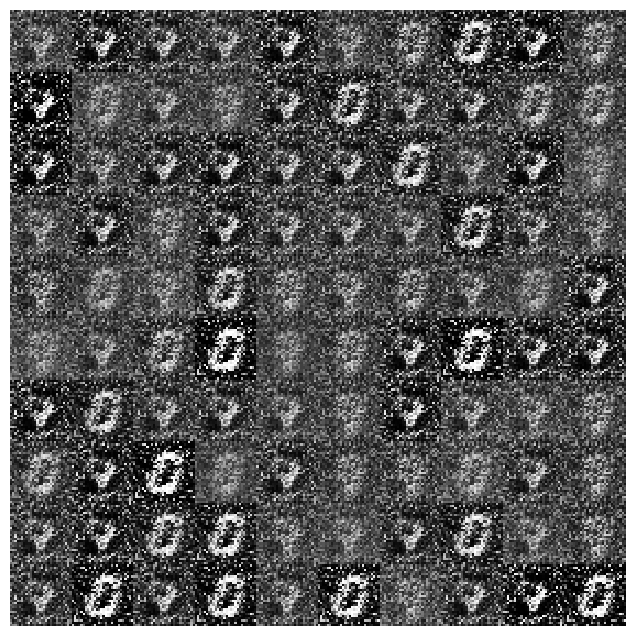

Epoch:   1
D Loss:  0.5182796716690063
G Loss:  1.0002177953720093
Epoch:   2
D Loss:  0.5804129242897034
G Loss:  1.094421148300171


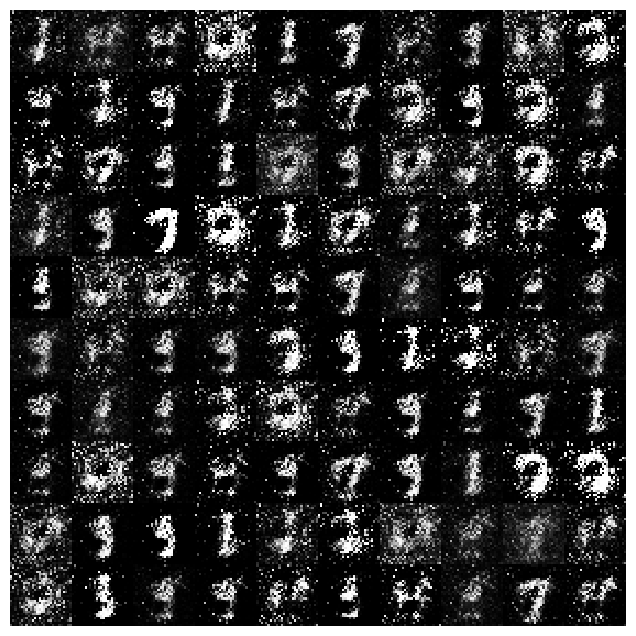

Epoch:   3
D Loss:  0.482925146818161
G Loss:  1.440093755722046
Epoch:   4
D Loss:  0.6078952550888062
G Loss:  0.7788512706756592


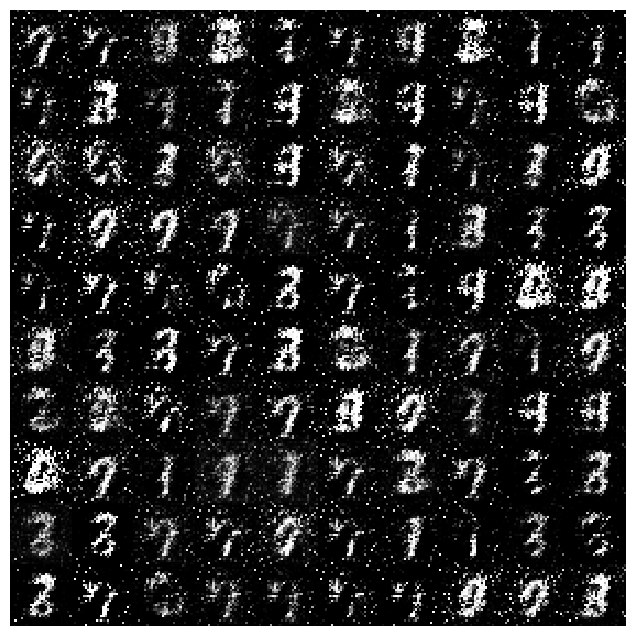

Epoch:   5
D Loss:  0.6515759229660034
G Loss:  0.7449779510498047
Epoch:   6
D Loss:  0.45195209980010986
G Loss:  1.4969102144241333


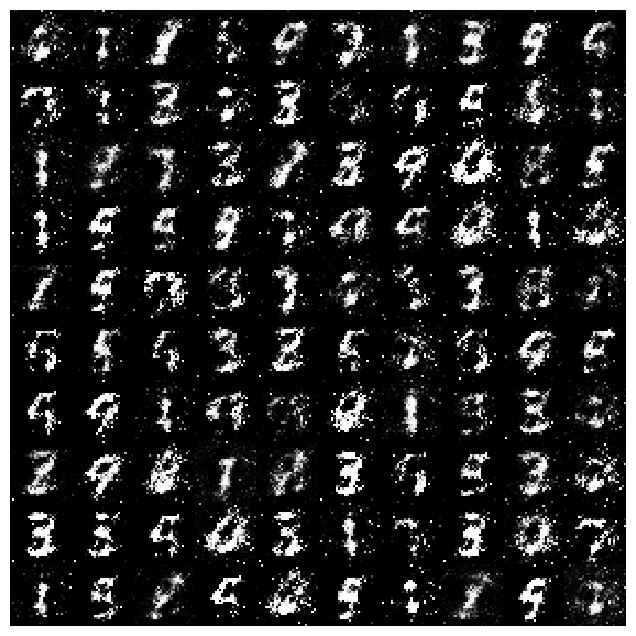

Epoch:   7
D Loss:  0.5115814208984375
G Loss:  1.0904144048690796
Epoch:   8
D Loss:  0.6092133522033691
G Loss:  1.6331613063812256


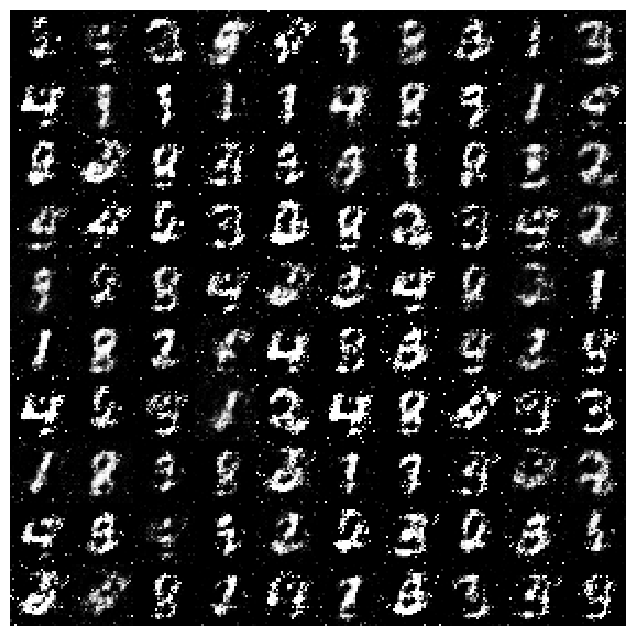

Epoch:   9
D Loss:  0.5214623808860779
G Loss:  1.027768611907959
Epoch:   10
D Loss:  0.5600129961967468
G Loss:  1.129488229751587


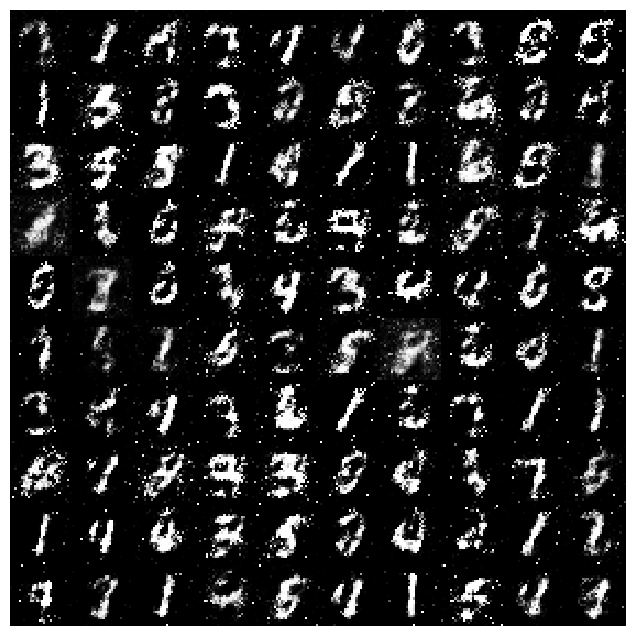

Epoch:   11
D Loss:  0.5706747174263
G Loss:  1.1659142971038818
Epoch:   12
D Loss:  0.5842983722686768
G Loss:  1.3894178867340088


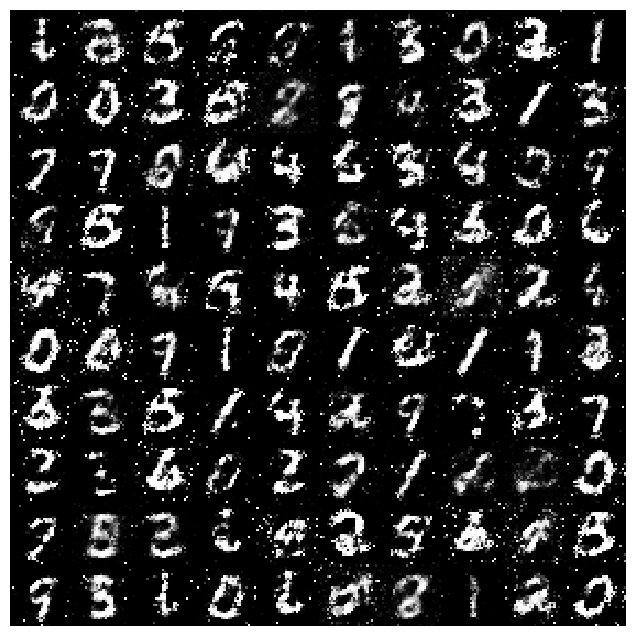

Epoch:   13
D Loss:  0.6001207232475281
G Loss:  1.0525362491607666
Epoch:   14
D Loss:  0.6456360816955566
G Loss:  0.6395334005355835


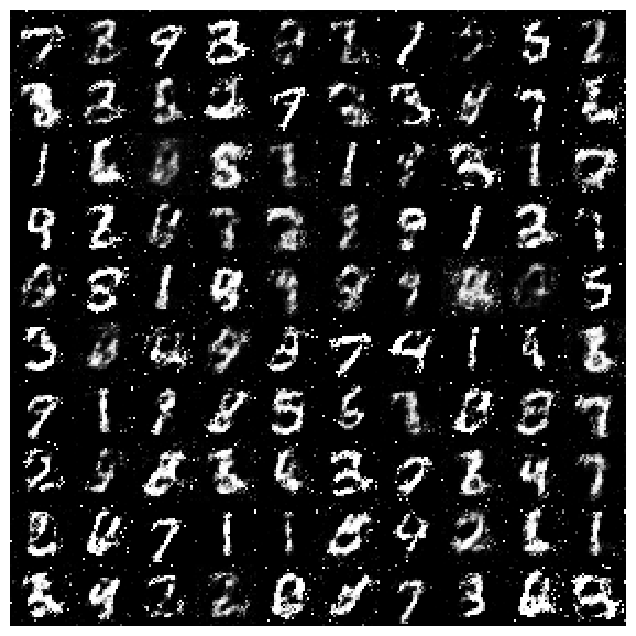

Epoch:   15
D Loss:  0.611079216003418
G Loss:  0.8921957612037659
Epoch:   16
D Loss:  0.6733485460281372
G Loss:  0.5163522958755493


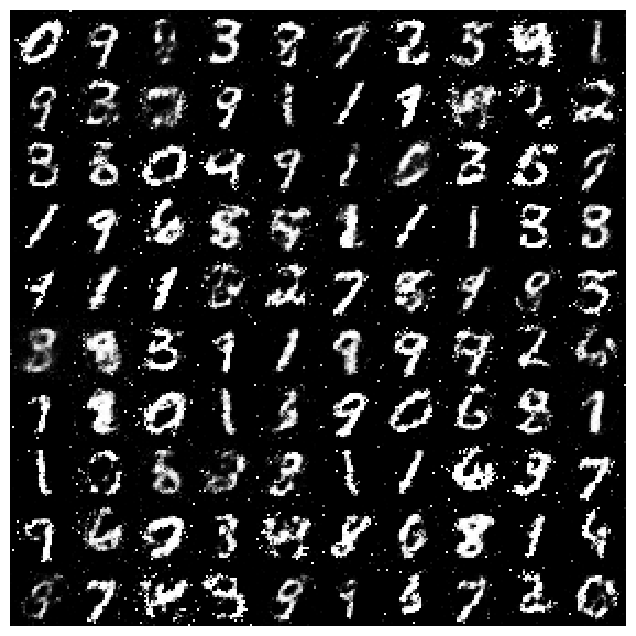

Epoch:   17
D Loss:  0.6130721569061279
G Loss:  1.1700571775436401
Epoch:   18
D Loss:  0.6041408777236938
G Loss:  1.0427221059799194


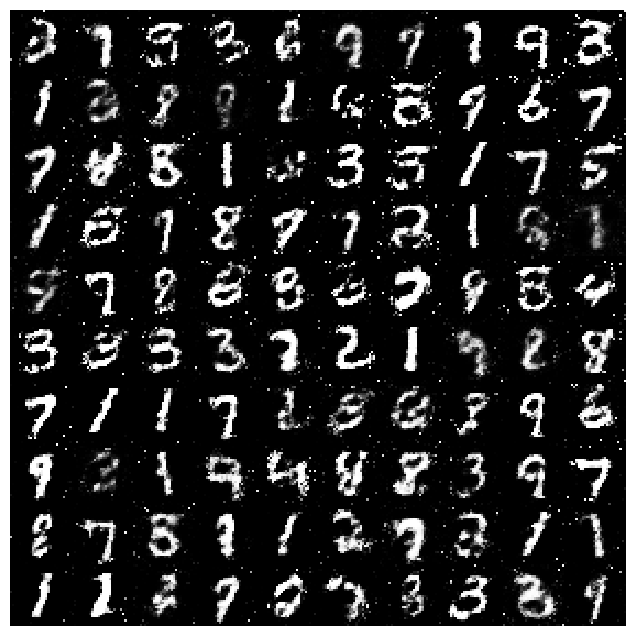

Epoch:   19
D Loss:  0.6126096248626709
G Loss:  1.172119140625
Epoch:   20
D Loss:  0.6017744541168213
G Loss:  0.8350030183792114


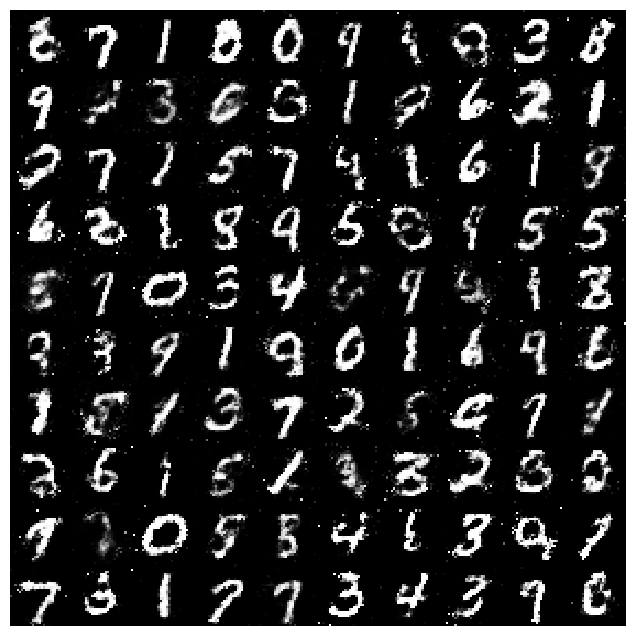

Epoch:   21
D Loss:  0.6403016448020935
G Loss:  0.6908735036849976
Epoch:   22
D Loss:  0.6622757911682129
G Loss:  0.6267183423042297


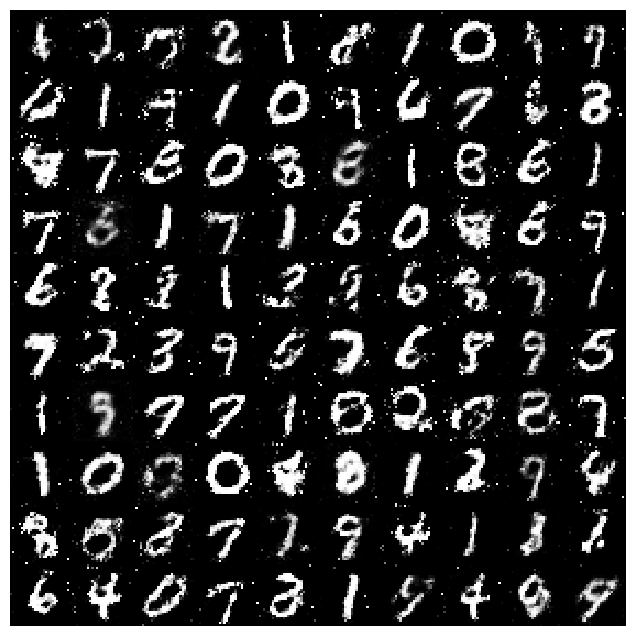

Epoch:   23
D Loss:  0.6079233884811401
G Loss:  1.097032904624939
Epoch:   24
D Loss:  0.609422504901886
G Loss:  0.880466103553772


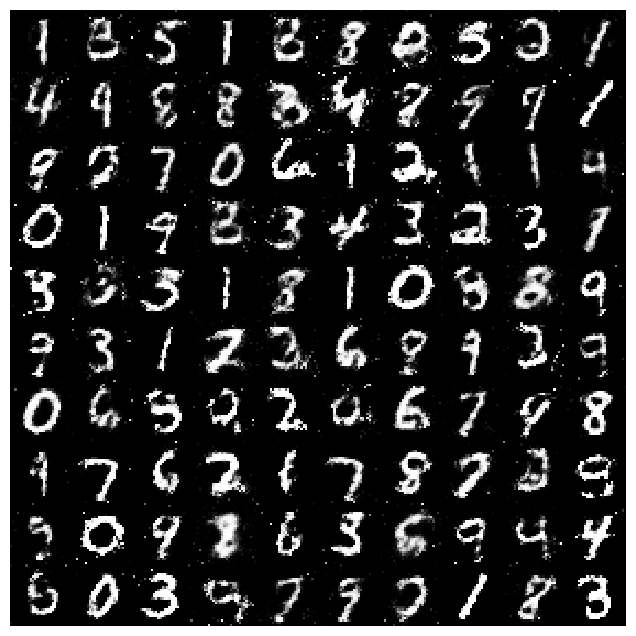

Epoch:   25
D Loss:  0.6341996192932129
G Loss:  0.6352838277816772
Epoch:   26
D Loss:  0.6775542497634888
G Loss:  1.4413501024246216


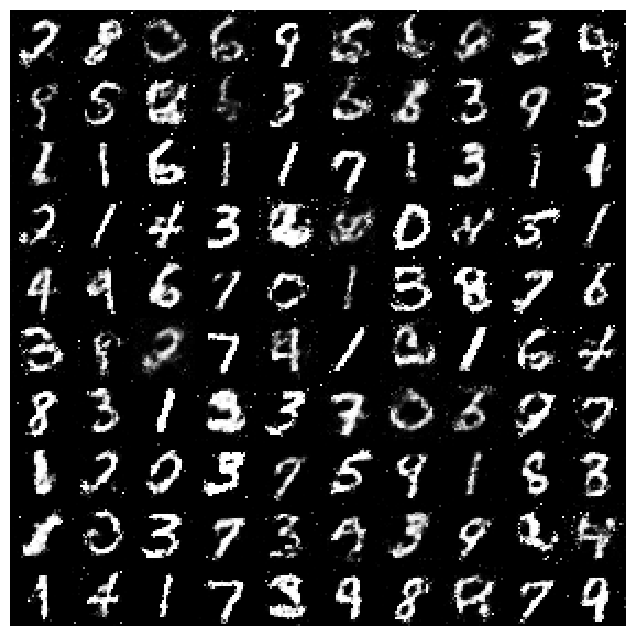

Epoch:   27
D Loss:  0.6367425322532654
G Loss:  1.1221495866775513
Epoch:   28
D Loss:  0.6135238409042358
G Loss:  0.7317302227020264


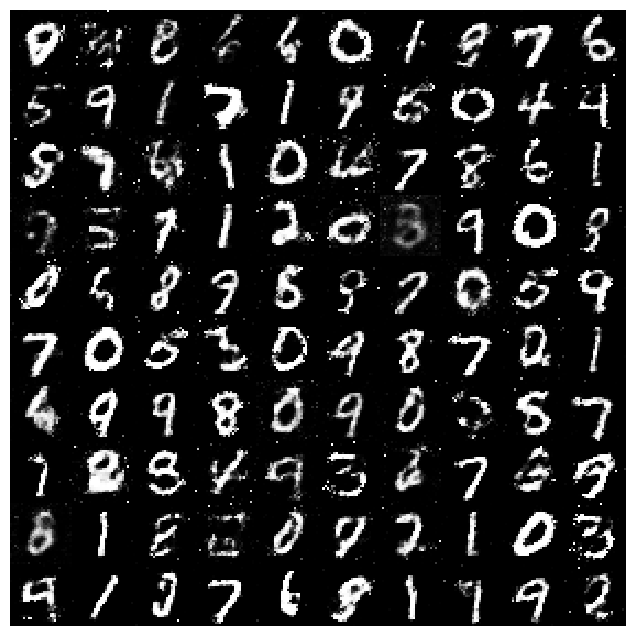

Epoch:   29
D Loss:  0.5843337774276733
G Loss:  0.9303305745124817
Epoch:   30
D Loss:  0.6027072668075562
G Loss:  0.8386178016662598


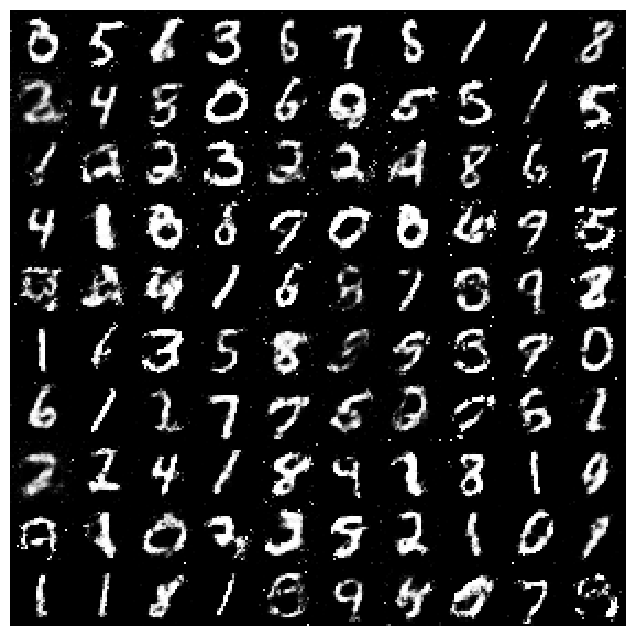

Epoch:   31
D Loss:  0.6030653119087219
G Loss:  0.9821564555168152
Epoch:   32
D Loss:  0.6406453847885132
G Loss:  0.8271423578262329


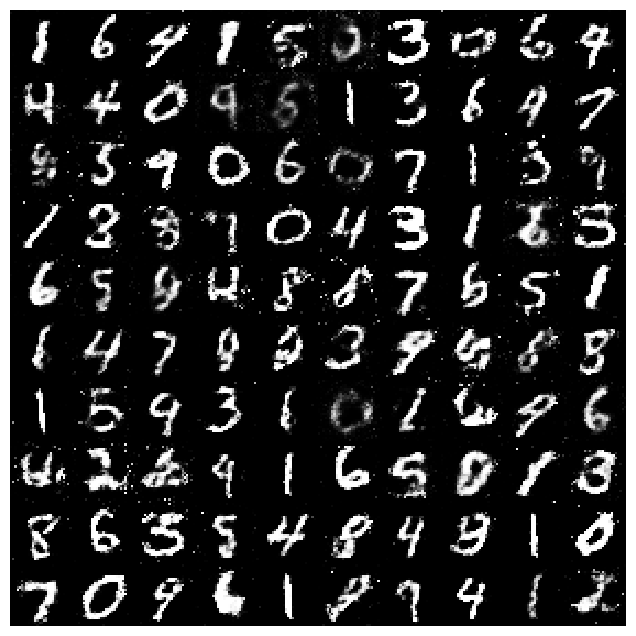

Epoch:   33
D Loss:  0.6084332466125488
G Loss:  0.8922139406204224
Epoch:   34
D Loss:  0.6350834369659424
G Loss:  0.8586915731430054


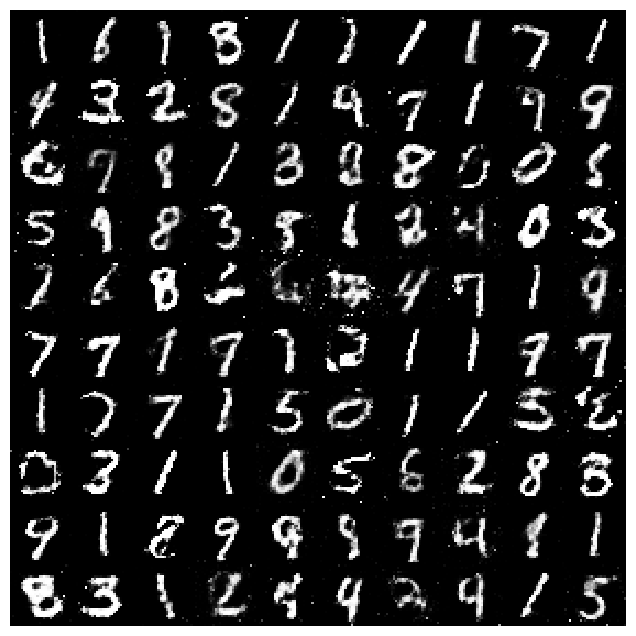

Epoch:   35
D Loss:  0.6044212579727173
G Loss:  0.9883085489273071
Epoch:   36
D Loss:  0.6816221475601196
G Loss:  1.1179676055908203


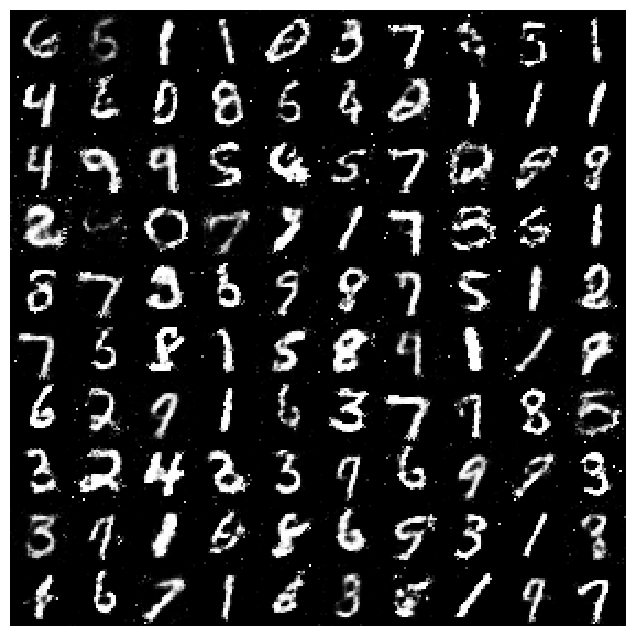

Epoch:   37
D Loss:  0.598752498626709
G Loss:  0.9248687624931335
Epoch:   38
D Loss:  0.58497554063797
G Loss:  0.8425590991973877


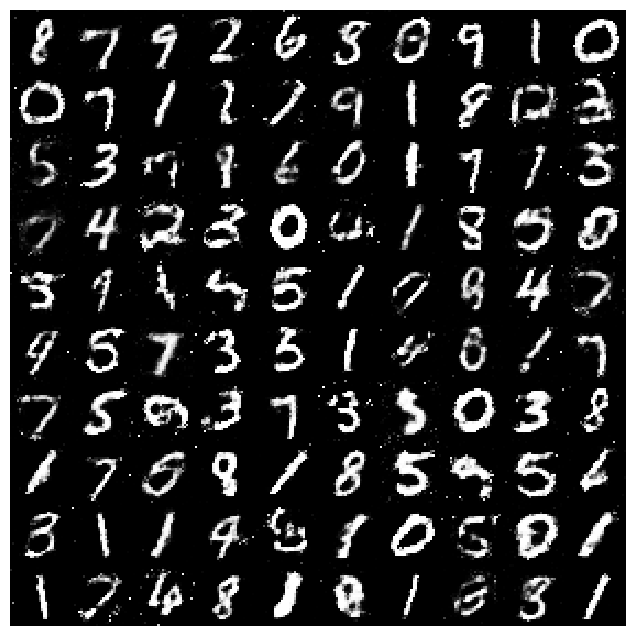

Epoch:   39
D Loss:  0.6102471351623535
G Loss:  0.8224995136260986


In [71]:
## Training loop

for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        
        # We set targets_real and targets_fake to non-binary values(soft and noisy labels).
        # This is a hack for stable training of GAN's.  
        # GAN hacks: https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
        
        targets_real = (torch.FloatTensor(images.size(0), 1).uniform_(0.8, 1.0))
        targets_fake = (torch.FloatTensor(images.size(0), 1).uniform_(0.0, 0.2))
                
        if is_cuda:
            targets_real = targets_real.cuda()
            targets_fake = targets_fake.cuda()
            images = images.cuda()
        
        ## D-STEP:
        ## First, clear the gradients of the Discriminator optimizer.
        ## Estimate logits_real by passing images through the Discriminator
        ## Generate fake_images by passing random noise through the Generator. Also, .detach() the fake images 
        ## as we don't compute the gradients of the Generator when optimizing Discriminator.
        ## fake_images = generator(noise(train_bs, noise_dim)).detach()
        ## Estimate logits_fake by passing the fake images through the Discriminator
        ## Compute the Discriminator loss by calling DLoss function.
        ## Compute the gradients by backpropagating through the computational graph. 
        ## Update the Discriminator parameters.
        
        
        ## G-STEP:
        ## clear the gradients of the Generator. 
        ## Generate fake images by passing random noise through the Generator. 
        ## Estimate logits_fake by passing the fake images through the Discriminator.
        ## compute the Generator loss by caling GLoss.
        ## compute the gradients by backpropagating through the computational graph.
        ## Update the Generator parameters. 
        
        # your code here
        # D-STEP
        optimizer_D.zero_grad()
        logits_real = discriminator(images)
        fake_images = generator(noise(train_bs, noise_dim)).detach()
        logits_fake = discriminator(fake_images)
        #print(logits_real.shape)
        #print(logits_fake.shape)
        #print(targets_real.shape)
        #print(targets_fake.shape)

        discriminator_loss = DLoss(logits_real,logits_fake,targets_real,targets_fake)
        discriminator_loss.backward()
        optimizer_D.step()

        # G-STEP
        optimizer_G.zero_grad()
        fake_images = generator(noise(train_bs, noise_dim))
        logits_fake = discriminator(fake_images)
        generator_loss = GLoss(logits_fake, targets_real)
        generator_loss.backward()
        optimizer_G.step()

    print("Epoch:  ", epoch)
    print("D Loss: ", discriminator_loss.item())
    print("G Loss: ", generator_loss.item())
          
    if epoch % 2 == 0:
        viz_batch = fake_images.data.cpu().numpy()
        viz_batch = viz_batch[:100,:,:,:]
        viz_batch = viz_batch.reshape(-1,28*28).squeeze()
        viz_batch = viz_batch.reshape(10,10, 28,28).transpose(0,2,1,3).reshape(28*10,-1)

        plt.figure(figsize = (8,8))
        plt.axis('off')
        plt.imshow(viz_batch, cmap='gray')
        plt.show()

#### The assignment is graded both manually and using auto-graded testcases.